# Homework 02: Multi-Class Classification with Neural Networks

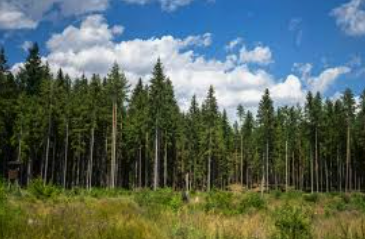

In this assignment, you’ll extend your Keras classification toolkit by training a neural network on a **balanced subset of the Forest Cover (Covertype) dataset**. We’ll begin with a simple baseline network, then study how performance changes as we vary **batch size**, **learning rate**, and apply a **cosine-decay schedule**.

For each configuration, you will consider a range of hyperparameter values, plot training/validation **loss** and **accuracy** over epochs, and determine which choice gave the best performance. 

Finally, you will consider all that you have learned and build your best model and run it on the test set. 


There are 9 graded questions, each worth 9 points, and you get 4 points for free if you complete the whole homework. 


In [1]:
# Useful imports

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_covtype

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import CosineDecay

random_seed = 42

tf.random.set_seed(random_seed)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING messages

$$k\cdot\sigma$$

In [2]:
# Utility function: Plotting Training Loss (categorical x-entropy) and Accuracy

# Takes the history object returned by fit

def plot_history(history):
    n_epochs = len(history.history['accuracy'])
    epochs = range(1, n_epochs + 1)

    plt.figure(figsize=(7, 8))

    plt.subplot(2, 1, 1)
    plt.plot(epochs, history.history['loss'], label='Training Loss (Xent)', color='tab:red')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.grid(True)
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy', color='tab:blue')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1.05)
    plt.title('Training Accuracy')
    plt.grid(True)
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

    final_loss = history.history['loss'][-1]
    final_acc = history.history['accuracy'][-1]
    print(f'Final Training Loss:     {final_loss:.4f}')
    print(f'Final Training Accuracy: {final_acc:.4f}')

## Load the dataset

The dataset is described in detail in the Appendix. For the purposes of this homework, we are selecting a random sample with 2747 samples in each class (to preserve balance), because the original dataset is both very large and very imbalanced, with the smallest class having 2747 samples. 

In [3]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import Counter
import numpy as np

# Load
X, y = fetch_covtype(return_X_y=True)   # y in {1..7}
classes, counts = np.unique(y, return_counts=True)
min_count = counts.min()                # size of rarest class (~2.7k)

# Build perfectly balanced subset (no replacement, no duplicates)
rng = np.random.default_rng(42)
idx_list = []
for c in classes:
    c_idx = np.where(y == c)[0]
    chosen = rng.choice(c_idx, size=min_count, replace=False)
    idx_list.append(chosen)

idx_bal = np.concatenate(idx_list)
rng.shuffle(idx_bal)

X_sub = X[idx_bal]
y_sub = y[idx_bal] - 1                  # relabel to 0..6 for Keras
print("Subset shape:", X_sub.shape, "Class counts:", Counter(y_sub))


Subset shape: (19229, 54) Class counts: Counter({np.int32(3): 2747, np.int32(2): 2747, np.int32(6): 2747, np.int32(5): 2747, np.int32(4): 2747, np.int32(1): 2747, np.int32(0): 2747})


## Problem One: Prepare the dataset and build a baseline model

### Part A: Stratified train/test split and standardization

As in Homework 1, follow these three steps:

1. **Stratified split:**
   Use `train_test_split` with `stratify=y_sub` to preserve class proportions in both training and test sets. Be sure to set `random_state=random_seed` and `test_size=0.2`.

2. **Standardize features:**
   Scale the input features so they have mean 0 and variance 1.



In [4]:
# Your code here
X_train, X_test, y_train, y_test = train_test_split(X_sub, y_sub, test_size=0.2, random_state=random_seed, stratify=y_sub)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Part B: Build, compile, train, and evaluate the network

1. **Build the model**

   * Use 2 hidden layers:  input &rarr; 64 &rarr; 32 &rarr; output.
   * Apply the `relu` activation for the hidden layers and `softmax` for the output layer.

2. **Compile the model**

    * Use the following parameters


           optimizer = Adam(learning_rate=0.0001),  
           loss = 'sparse_categorical_crossentropy',  
           metrics = ['accuracy']


4. **Train the model**

   * Run for **20 epochs**.
   * Use a `batch_size` of 32.

5. **Evaluate training**

   * Plot the training loss and accuracy curves using `plot_history`.

6. **Answer the graded questions**



Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 311us/step - accuracy: 0.3867 - loss: 1.7151
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step - accuracy: 0.5473 - loss: 1.2750
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step - accuracy: 0.5975 - loss: 1.0491
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step - accuracy: 0.6267 - loss: 0.9420
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step - accuracy: 0.6462 - loss: 0.8847
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step - accuracy: 0.6620 - loss: 0.8477
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step - accuracy: 0.6711 - loss: 0.8207
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step - accuracy: 0.6811 - loss: 0.7993
Epoch 9/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step - accuracy: 0.6876 - loss: 0.7814
Epoch 10/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step - accuracy: 0.6947 - loss: 0.7659
Epoch 11/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step - accuracy: 0.6987 - loss: 0.7523
Epoch 12/20
481/481 ━━━━━━━━━━

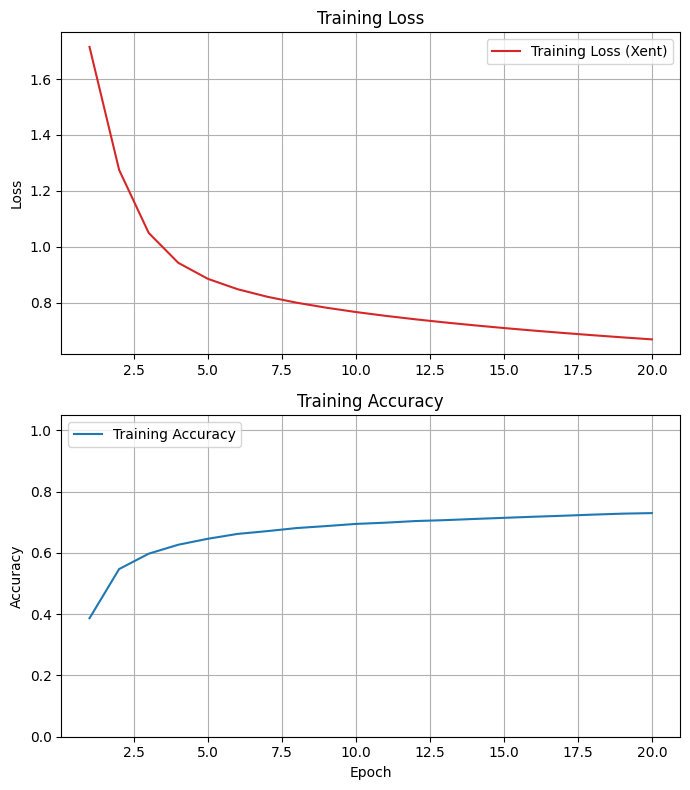

Final Training Loss:     0.6680
Final Training Accuracy: 0.7300


In [5]:
# Your code here
num_features = X_train.shape[1]
num_classes = len(np.unique(y_train))

model = Sequential([
    Input(shape=(num_features,)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
epochs = 20
batch_size = 32

history = model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=1)

# Plot training history
plot_history(history)

In [6]:
# Set a1a to the final training accuracy at epoch 20

a1a = history.history['accuracy'][-1]

In [7]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a1a = {a1a:.4f}')  

a1a = 0.7300


## Problem Two: Batch Sizes

Next, we’ll explore how the **batch size** affects training. .

* Start with the code from Problem One.
* Run **four experiments** using a batch size of 4, 8, 16, and 128, and  displaying the results using `plot_history`.

* Answer the graded questions.

**Note:** Consider using a `for` loop!


Training with batch size: 4
Epoch 1/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 1s 265us/step - accuracy: 0.4662 - loss: 1.3886
Epoch 2/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 1s 269us/step - accuracy: 0.6368 - loss: 0.8959
Epoch 3/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 1s 270us/step - accuracy: 0.6725 - loss: 0.8076
Epoch 4/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 1s 266us/step - accuracy: 0.6899 - loss: 0.7627
Epoch 5/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 1s 267us/step - accuracy: 0.7011 - loss: 0.7298
Epoch 6/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 1s 271us/step - accuracy: 0.7119 - loss: 0.7030
Epoch 7/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 1s 265us/step - accuracy: 0.7194 - loss: 0.6803
Epoch 8/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 1s 263us/step - accuracy: 0.7244 - loss: 0.6606
Epoch 9/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 1s 266us/step - accuracy: 0.7309 - loss: 0.6436
Epoch 10/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 1s 266us/step - accuracy: 0.7375 - loss: 0.6288
Epoch 11/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 1s 267us/step - accuracy: 0

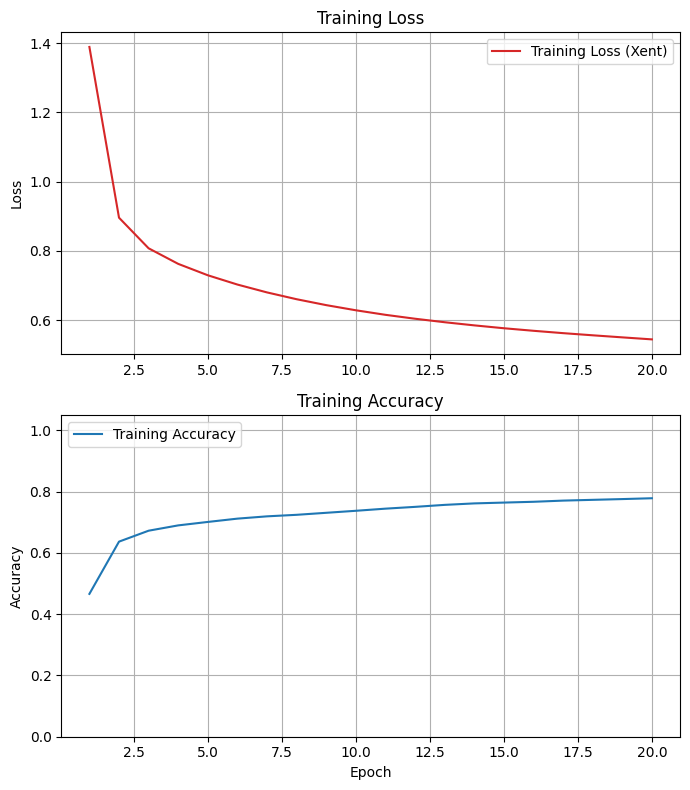

Final Training Loss:     0.5448
Final Training Accuracy: 0.7785

Training with batch size: 8
Epoch 1/20
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 1s 276us/step - accuracy: 0.4679 - loss: 1.5213
Epoch 2/20
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 1s 269us/step - accuracy: 0.6218 - loss: 0.9659
Epoch 3/20
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 1s 271us/step - accuracy: 0.6537 - loss: 0.8495
Epoch 4/20
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 1s 270us/step - accuracy: 0.6707 - loss: 0.7996
Epoch 5/20
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 1s 278us/step - accuracy: 0.6856 - loss: 0.7660
Epoch 6/20
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 1s 271us/step - accuracy: 0.6962 - loss: 0.7402
Epoch 7/20
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 1s 265us/step - accuracy: 0.7063 - loss: 0.7191
Epoch 8/20
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 1s 264us/step - accuracy: 0.7142 - loss: 0.7010
Epoch 9/20
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 1s 263us/step - accuracy: 0.7192 - loss: 0.6856
Epoch 10/20
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 1s 264us/step - accuracy: 0.7270 - loss: 0.6717
Epoch 

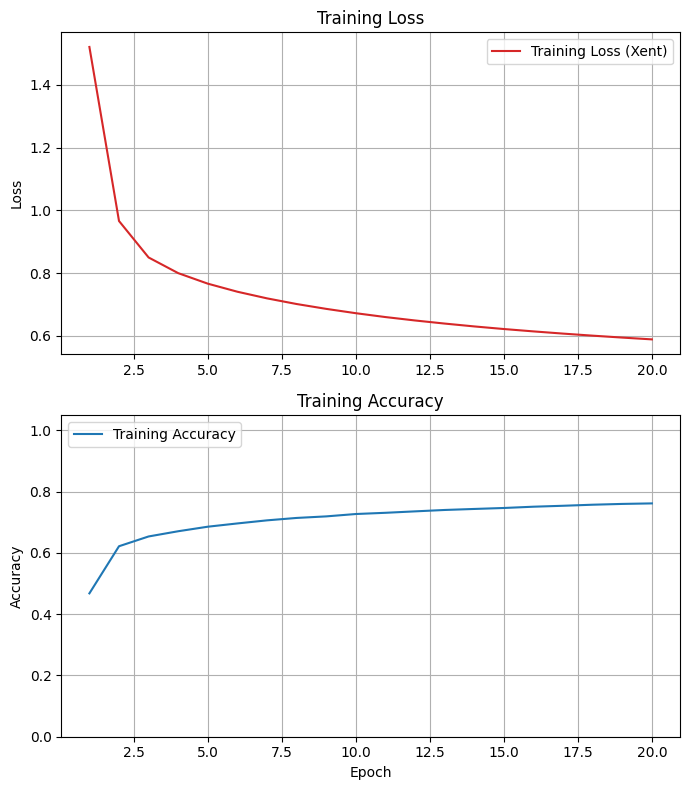

Final Training Loss:     0.5882
Final Training Accuracy: 0.7616

Training with batch size: 16
Epoch 1/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 1s 287us/step - accuracy: 0.4316 - loss: 1.5437
Epoch 2/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step - accuracy: 0.5940 - loss: 1.0499
Epoch 3/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step - accuracy: 0.6292 - loss: 0.9018
Epoch 4/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step - accuracy: 0.6549 - loss: 0.8395
Epoch 5/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step - accuracy: 0.6765 - loss: 0.7995
Epoch 6/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step - accuracy: 0.6882 - loss: 0.7706
Epoch 7/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step - accuracy: 0.6964 - loss: 0.7478
Epoch 8/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step - accuracy: 0.7038 - loss: 0.7288
Epoch 9/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step - accuracy: 0.7105 - loss: 0.7124
Epoch 10/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step - accuracy: 0.7172 - loss: 0.6979
Epoch 11/20
962/962 ━━━━━

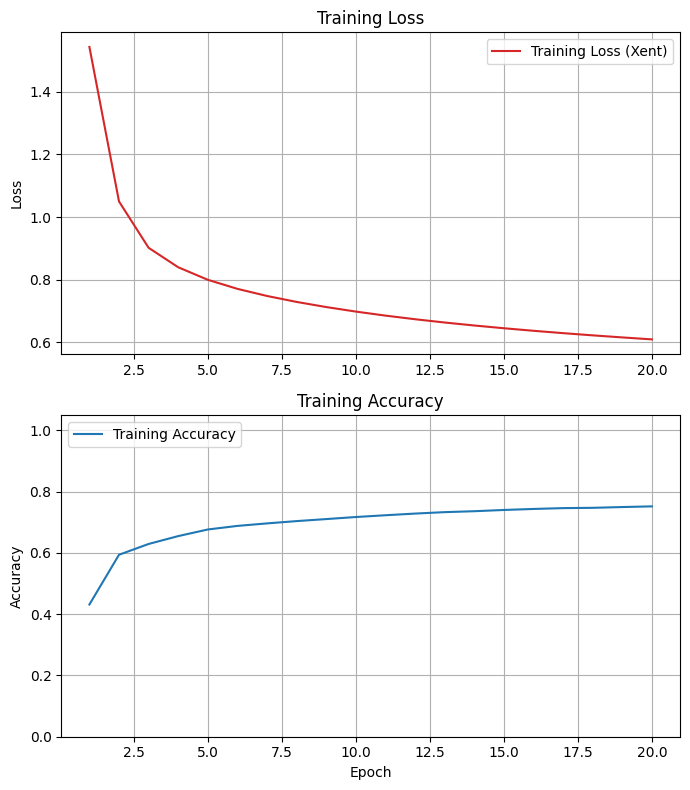

Final Training Loss:     0.6091
Final Training Accuracy: 0.7519

Training with batch size: 128
Epoch 1/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - accuracy: 0.2117 - loss: 1.9449 
Epoch 2/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step - accuracy: 0.3874 - loss: 1.7387
Epoch 3/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step - accuracy: 0.5016 - loss: 1.5612
Epoch 4/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step - accuracy: 0.5442 - loss: 1.3969
Epoch 5/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step - accuracy: 0.5693 - loss: 1.2553
Epoch 6/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step - accuracy: 0.5853 - loss: 1.1469
Epoch 7/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step - accuracy: 0.5969 - loss: 1.0672
Epoch 8/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step - accuracy: 0.6093 - loss: 1.0088
Epoch 9/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - accuracy: 0.6214 - loss: 0.9660
Epoch 10/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step - accuracy: 0.6312 - loss: 0.9339
Epoch 11/20
121/121 ━━━

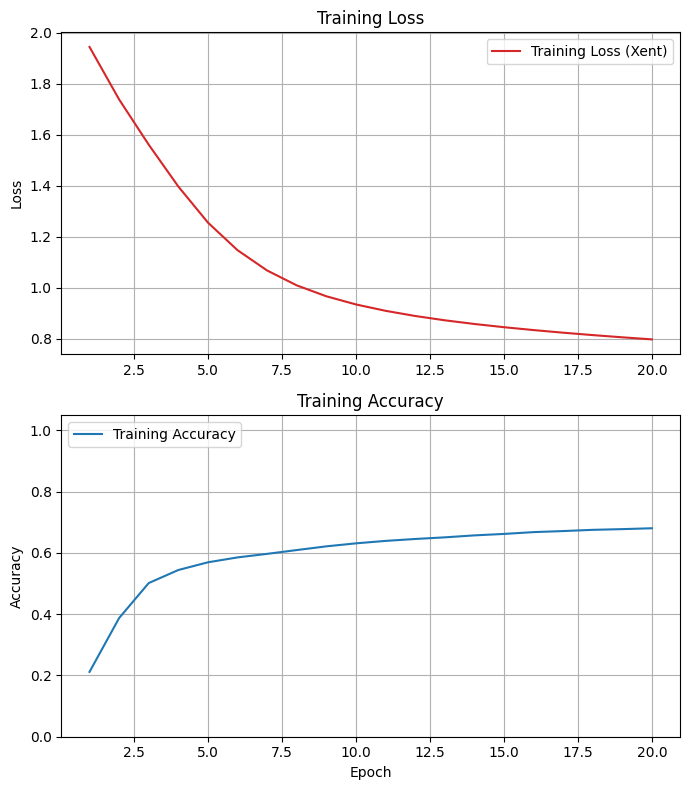

Final Training Loss:     0.7967
Final Training Accuracy: 0.6805


In [8]:
# Your code here
batch_sizes = [4, 8, 16, 128]
# Store best accuracy and corresponding batch size
best_batch_accuracy = 0.0
best_batch_size = 0
for experiment in batch_sizes:
    print(f'\nTraining with batch size: {experiment}')
    model = Sequential([
        Input(shape=(num_features,)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    # Compile the model
    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Train the model
    epochs = 20

    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=experiment,
                        verbose=1)

    # Plot training history
    plot_history(history)

    if history.history['accuracy'][-1] > best_batch_accuracy:
        best_batch_accuracy = history.history['accuracy'][-1]
        best_batch_size = experiment

In [9]:
# Set a2a to the batch size which produced the best accuracy score at epoch 20

a2a = best_batch_size

In [10]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a2a = {a2a}') 

a2a = 4


In [11]:
# Set a2b to the best accuracy score found

a2b = best_batch_accuracy

In [12]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a2b = {a2b:.4f}') 

a2b = 0.7785


## Problem Three: Learning Rates

Next, we’ll explore how the **learning rate** affects training when using the Adam optimizer.

* Start with the code from **Problem One**.
* Add the `learning_rate` parameter to `Adam`.
* Run **five experiments** using the following values:

        [1e-3, 5e-4, 1e-4,5e-5, 1e-5]

* Display your results using `plot_history` and answer the graded questions.



Training with learning rate: 0.001
Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 312us/step - accuracy: 0.5849 - loss: 1.0333
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step - accuracy: 0.6938 - loss: 0.7269
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step - accuracy: 0.7265 - loss: 0.6565
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step - accuracy: 0.7445 - loss: 0.6160
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step - accuracy: 0.7547 - loss: 0.5880
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step - accuracy: 0.7634 - loss: 0.5666
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step - accuracy: 0.7716 - loss: 0.5501
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step - accuracy: 0.7772 - loss: 0.5369
Epoch 9/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step - accuracy: 0.7831 - loss: 0.5252
Epoch 10/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step - accuracy: 0.7873 - loss: 0.5147
Epoch 11/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step - accuracy: 0.7907 - loss: 0

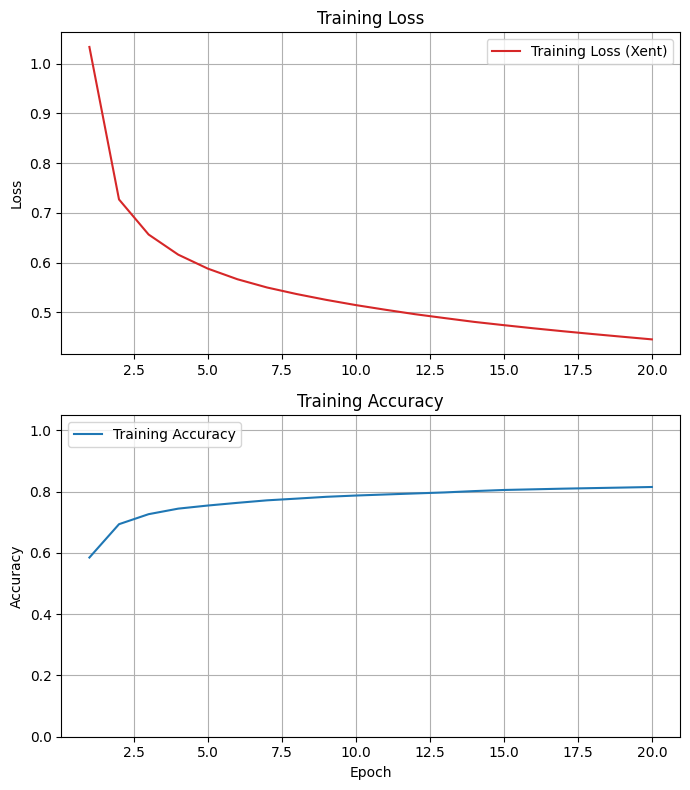

Final Training Loss:     0.4458
Final Training Accuracy: 0.8152

Training with learning rate: 0.0005
Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 308us/step - accuracy: 0.5277 - loss: 1.2302
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step - accuracy: 0.6658 - loss: 0.8191
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step - accuracy: 0.6977 - loss: 0.7430
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step - accuracy: 0.7195 - loss: 0.6970
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step - accuracy: 0.7313 - loss: 0.6639
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step - accuracy: 0.7406 - loss: 0.6384
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step - accuracy: 0.7478 - loss: 0.6182
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step - accuracy: 0.7543 - loss: 0.6016
Epoch 9/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step - accuracy: 0.7590 - loss: 0.5876
Epoch 10/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step - accuracy: 0.7623 - loss: 0.5751
Epoch 11/20
481/48

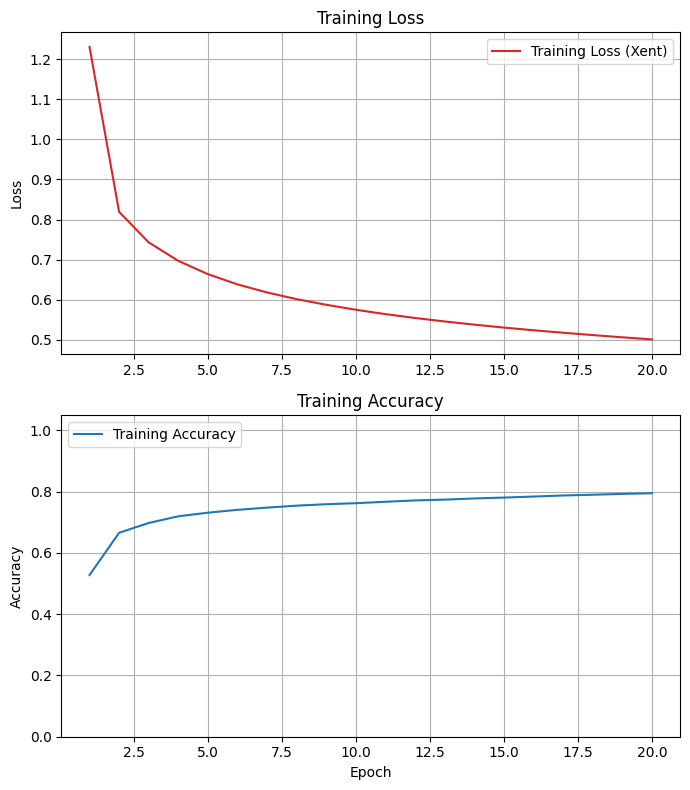

Final Training Loss:     0.5013
Final Training Accuracy: 0.7948

Training with learning rate: 0.0001
Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 314us/step - accuracy: 0.3240 - loss: 1.7715
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step - accuracy: 0.5485 - loss: 1.3004
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step - accuracy: 0.5974 - loss: 1.0472
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step - accuracy: 0.6243 - loss: 0.9320
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step - accuracy: 0.6443 - loss: 0.8727
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step - accuracy: 0.6588 - loss: 0.8366
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step - accuracy: 0.6702 - loss: 0.8109
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step - accuracy: 0.6793 - loss: 0.7905
Epoch 9/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step - accuracy: 0.6867 - loss: 0.7729
Epoch 10/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step - accuracy: 0.6917 - loss: 0.7577
Epoch 11/20
481/48

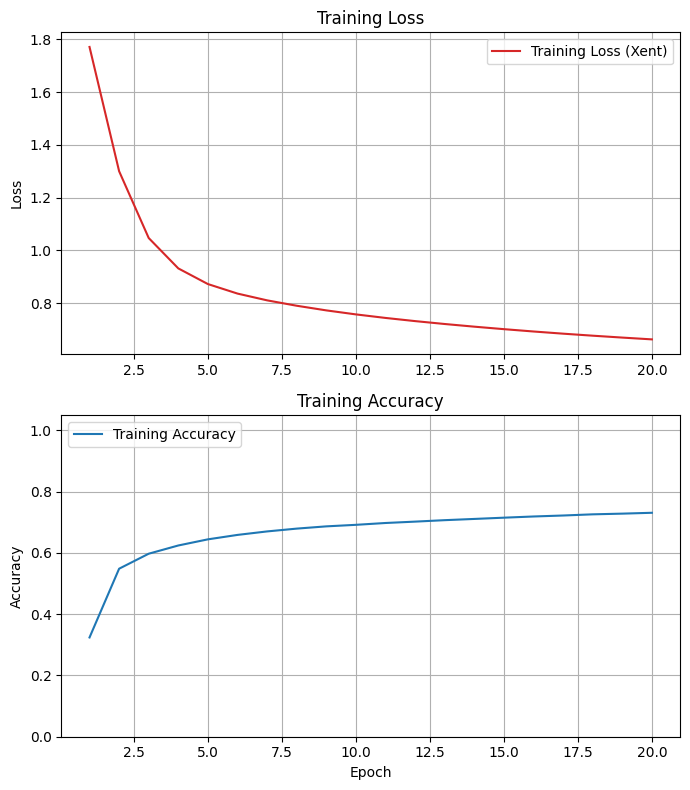

Final Training Loss:     0.6630
Final Training Accuracy: 0.7310

Training with learning rate: 5e-05
Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 310us/step - accuracy: 0.2385 - loss: 1.9698
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step - accuracy: 0.4358 - loss: 1.6092
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step - accuracy: 0.5241 - loss: 1.3696
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step - accuracy: 0.5678 - loss: 1.2039
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step - accuracy: 0.5915 - loss: 1.0942
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step - accuracy: 0.6068 - loss: 1.0207
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step - accuracy: 0.6157 - loss: 0.9694
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step - accuracy: 0.6240 - loss: 0.9317
Epoch 9/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step - accuracy: 0.6319 - loss: 0.9023
Epoch 10/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step - accuracy: 0.6401 - loss: 0.8787
Epoch 11/20
481/481

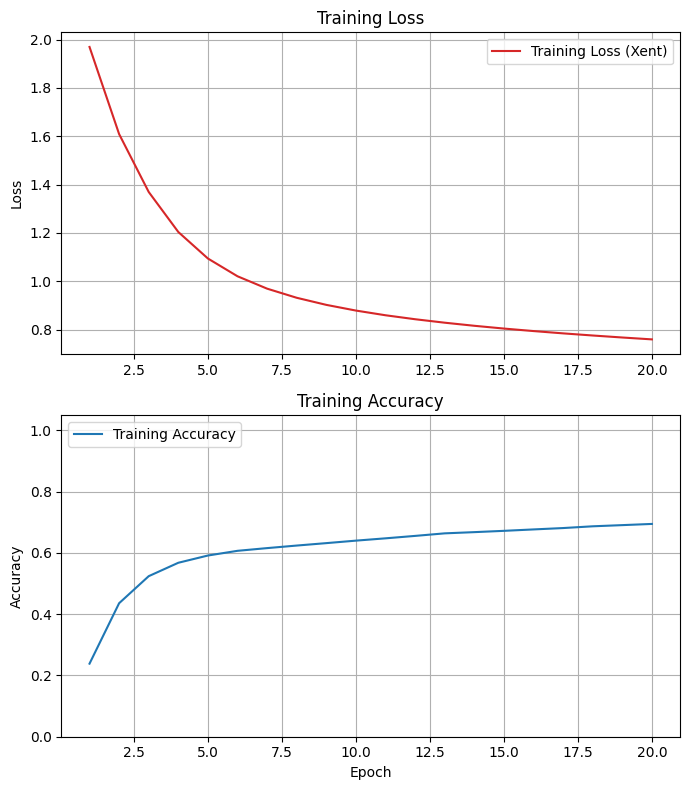

Final Training Loss:     0.7595
Final Training Accuracy: 0.6946

Training with learning rate: 1e-05
Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 317us/step - accuracy: 0.1599 - loss: 2.0599
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step - accuracy: 0.2183 - loss: 1.9493
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step - accuracy: 0.2785 - loss: 1.8576
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step - accuracy: 0.3271 - loss: 1.7774
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step - accuracy: 0.3858 - loss: 1.7041
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step - accuracy: 0.4314 - loss: 1.6373
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step - accuracy: 0.4649 - loss: 1.5761
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step - accuracy: 0.4835 - loss: 1.5196
Epoch 9/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step - accuracy: 0.5001 - loss: 1.4671
Epoch 10/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step - accuracy: 0.5142 - loss: 1.4183
Epoch 11/20
481/481

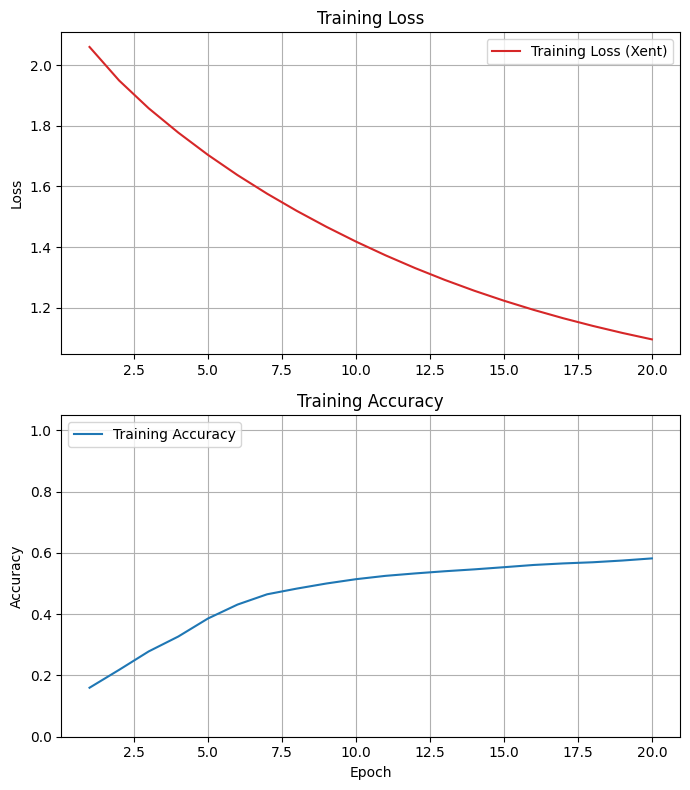

Final Training Loss:     1.0958
Final Training Accuracy: 0.5821


In [13]:
# Your code here

experiments = [1e-3, 5e-4, 1e-4, 5e-5, 1e-5]
best_lr_accuracy = 0.0
best_lr = 0.0
for experiment in experiments:
    print(f'\nTraining with learning rate: {experiment}')
    model = Sequential([
    Input(shape=(num_features,)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')])

    # Compile the model
    optimizer = Adam(learning_rate=experiment)
    model.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

    # Train the model
    epochs = 20
    batch_size = 32

    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        verbose=1)

    # Plot training history
    plot_history(history)

    if history.history['accuracy'][-1] > best_lr_accuracy:
        best_lr_accuracy = history.history['accuracy'][-1]
        best_lr = experiment

In [14]:
# Set a3a to the learning rate which produces the best (largest) accuracy at epoch 20

a3a = best_lr

In [15]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a3a = {a3a:.4f}') 

a3a = 0.0010


In [16]:
# Set a3b to the accuracy found by the best learning rate

a3b = best_lr_accuracy

In [17]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a3b = {a3b:.4f}') 

a3b = 0.8152


## Problem Four: Cosine Decay Learning Rate Scheduling

In this problem we'll gain some experience using the Cosine Decay learning rate scheduler with Adam. 

* Start with the code from **Problem One**.
* Define a `CosineDecay` learning rate scheduler (see `Week02_Coding.ipynb` for details)
* Use the scheduler with the Adam optimzier
* Run **five experiments** using the following values for `initial_learning_rate`:

        [1e-2, 5e-3, 1e-3,5e-4, 1e-4]

* Display your results using `plot_history` and answer the graded questions.


Training with initial learning rate: 0.01
Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 313us/step - accuracy: 0.6584 - loss: 0.8249
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step - accuracy: 0.7171 - loss: 0.6703
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step - accuracy: 0.7400 - loss: 0.6230
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step - accuracy: 0.7535 - loss: 0.5933
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step - accuracy: 0.7639 - loss: 0.5647
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step - accuracy: 0.7738 - loss: 0.5405
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step - accuracy: 0.7833 - loss: 0.5172
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step - accuracy: 0.7957 - loss: 0.4878
Epoch 9/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step - accuracy: 0.8052 - loss: 0.4660
Epoch 10/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step - accuracy: 0.8176 - loss: 0.4394
Epoch 11/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step - accuracy: 0.8227 - 

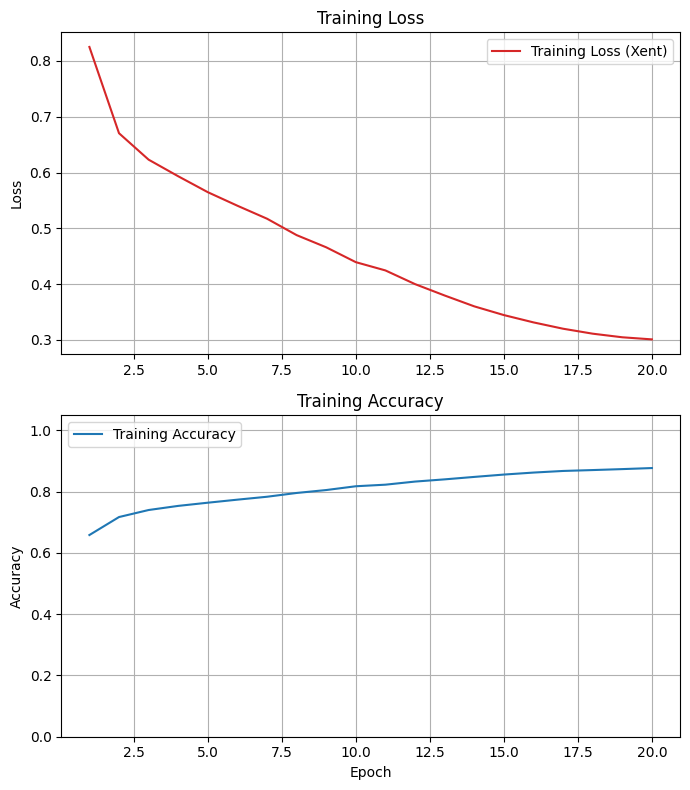

Final Training Loss:     0.3011
Final Training Accuracy: 0.8770

Training with initial learning rate: 0.005
Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 312us/step - accuracy: 0.6582 - loss: 0.8193
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step - accuracy: 0.7226 - loss: 0.6506
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step - accuracy: 0.7479 - loss: 0.5971
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step - accuracy: 0.7606 - loss: 0.5636
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step - accuracy: 0.7765 - loss: 0.5349
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step - accuracy: 0.7866 - loss: 0.5085
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step - accuracy: 0.7987 - loss: 0.4817
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step - accuracy: 0.8088 - loss: 0.4567
Epoch 9/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step - accuracy: 0.8193 - loss: 0.4366
Epoch 10/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step - accuracy: 0.8294 - loss: 0.4151
Epoch 11/20

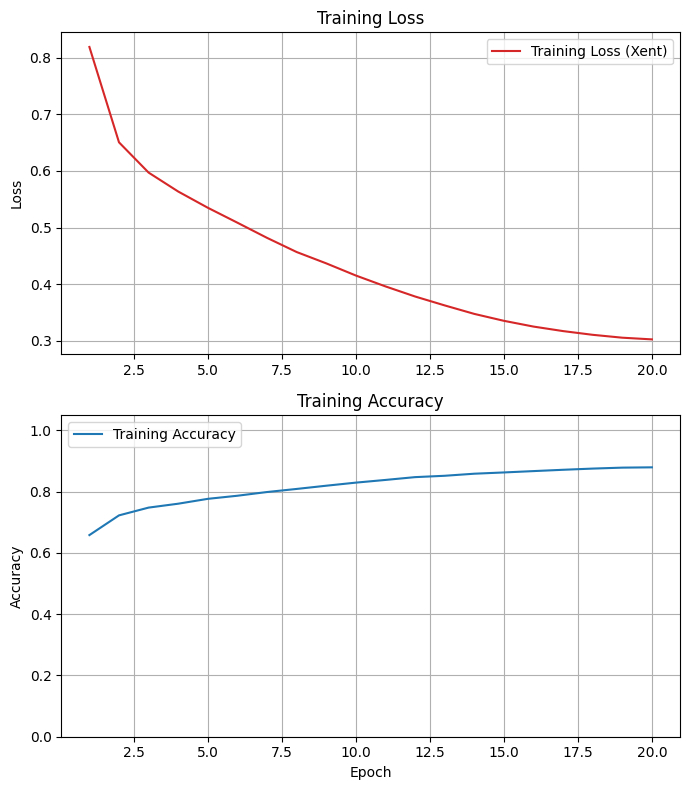

Final Training Loss:     0.3022
Final Training Accuracy: 0.8793

Training with initial learning rate: 0.001
Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 308us/step - accuracy: 0.6074 - loss: 1.0048
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step - accuracy: 0.6982 - loss: 0.7365
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step - accuracy: 0.7197 - loss: 0.6719
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step - accuracy: 0.7395 - loss: 0.6307
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step - accuracy: 0.7526 - loss: 0.6019
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step - accuracy: 0.7619 - loss: 0.5807
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step - accuracy: 0.7691 - loss: 0.5635
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step - accuracy: 0.7742 - loss: 0.5489
Epoch 9/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step - accuracy: 0.7807 - loss: 0.5361
Epoch 10/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step - accuracy: 0.7862 - loss: 0.5254
Epoch 11/20

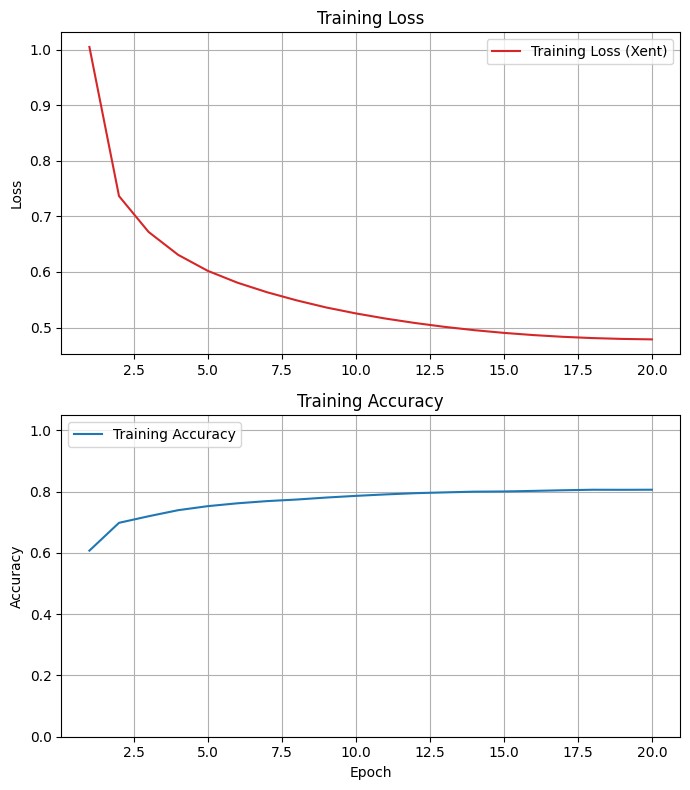

Final Training Loss:     0.4787
Final Training Accuracy: 0.8063

Training with initial learning rate: 0.0005
Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 303us/step - accuracy: 0.5570 - loss: 1.1873
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step - accuracy: 0.6666 - loss: 0.8168
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step - accuracy: 0.6997 - loss: 0.7409
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step - accuracy: 0.7176 - loss: 0.6971
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step - accuracy: 0.7274 - loss: 0.6667
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step - accuracy: 0.7380 - loss: 0.6429
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step - accuracy: 0.7467 - loss: 0.6238
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step - accuracy: 0.7525 - loss: 0.6083
Epoch 9/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step - accuracy: 0.7571 - loss: 0.5956
Epoch 10/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step - accuracy: 0.7606 - loss: 0.5851
Epoch 11/2

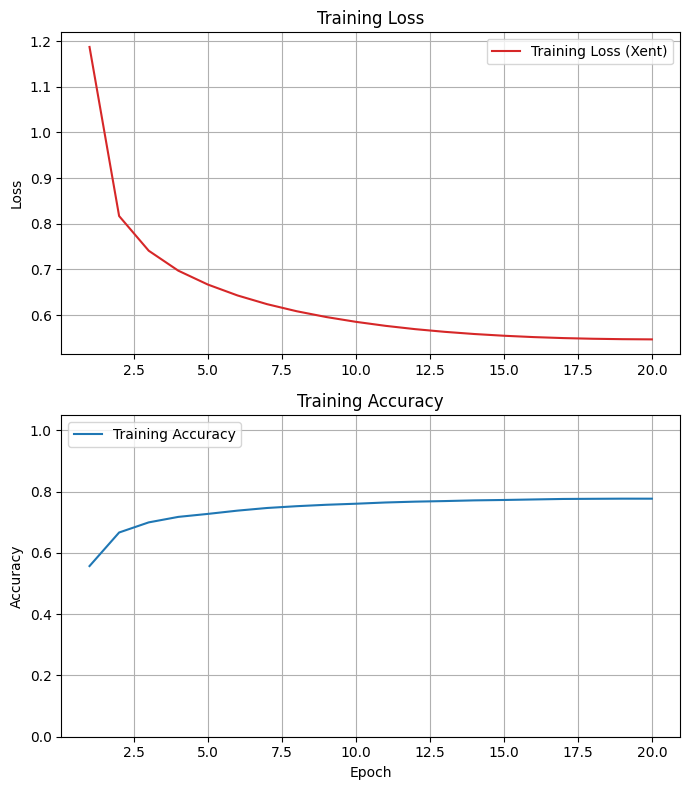

Final Training Loss:     0.5466
Final Training Accuracy: 0.7770

Training with initial learning rate: 0.0001
Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 313us/step - accuracy: 0.2880 - loss: 1.8482
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step - accuracy: 0.5208 - loss: 1.4262
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step - accuracy: 0.5971 - loss: 1.1149
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step - accuracy: 0.6221 - loss: 0.9703
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step - accuracy: 0.6365 - loss: 0.9017
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step - accuracy: 0.6482 - loss: 0.8608
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step - accuracy: 0.6590 - loss: 0.8336
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step - accuracy: 0.6678 - loss: 0.8144
Epoch 9/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step - accuracy: 0.6748 - loss: 0.8001
Epoch 10/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step - accuracy: 0.6803 - loss: 0.7889
Epoch 11/2

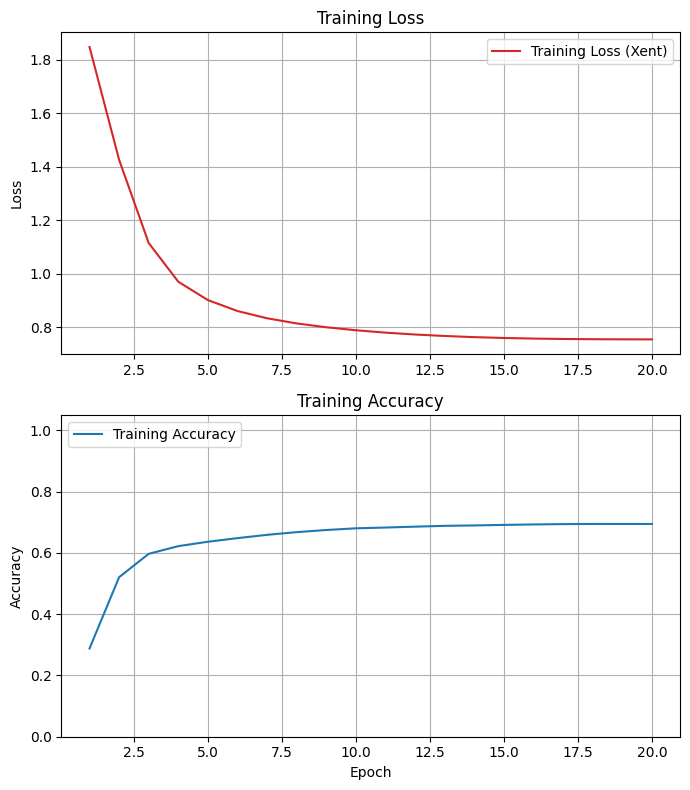

Final Training Loss:     0.7548
Final Training Accuracy: 0.6945


In [18]:
# Your code here

experiments = [1e-2, 5e-3, 1e-3, 5e-4, 1e-4]
best_ilr_accuracy = 0.0
best_ilr = 0.0
for experiment in experiments:
    print(f'\nTraining with initial learning rate: {experiment}')

    # Compute the number of steps (batches) per epoch

    steps_per_epoch = int(np.ceil(len(X_train) / batch_size))

    # Total number of training steps (needed for per-step schedulers like CosineDecay)

    total_steps = epochs * steps_per_epoch
    initial_lr = experiment

    # CosineDecay schedule (per-step)
    lr_schedule = CosineDecay(
        initial_learning_rate=initial_lr,
        decay_steps=total_steps,
        alpha=0.0  # Final LR = 0
    )

    model = Sequential([
    Input(shape=(num_features,)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')])

    # Compile the model
    optimizer = Adam(learning_rate=experiment)
    model.compile(optimizer=Adam(learning_rate=lr_schedule),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

    # Train the model
    epochs = 20
    batch_size = 32

    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        verbose=1)

    # Plot training history
    plot_history(history)

    if history.history['accuracy'][-1] > best_ilr_accuracy:
        best_ilr_accuracy = history.history['accuracy'][-1]
        best_ilr = experiment

In [19]:
# Set a4a to the initial learning rate which produced the best accuracy

a4a = best_ilr

In [20]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a4a = {a4a:.4f}') 

a4a = 0.0050


In [21]:
# Set a4b to the best accuracy found

a4b = best_ilr_accuracy

In [22]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a4b = {a4b:.4f}') 

a4b = 0.8793


## Problem Five: Find the best model and run on the test set

In this final problem, you must consider all the experiments you've done and pick the
set of training hyperparameters which gives you the best accuracy after 20 epochs. Do not change the model architecture. 

Your choices are:

- Which batch size?
- Cosine Decay or constant learning rate?
    - If Cosine Decay, which initial learning rate?
    - If not, which constant learning rate?

* Display your results using `plot_history`
* Run your best model on the test set
* Answer the graded questions.


**OPTIONAL: change the model architecture (but use only dense layers) and try other learning rate schedulers (exponential, step, etc.)**

Epoch 1/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 1s 270us/step - accuracy: 0.6564 - loss: 0.8127
Epoch 2/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 1s 269us/step - accuracy: 0.7447 - loss: 0.6044
Epoch 3/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 1s 269us/step - accuracy: 0.7857 - loss: 0.5183
Epoch 4/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 1s 265us/step - accuracy: 0.7880 - loss: 0.5108
Epoch 5/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 1s 265us/step - accuracy: 0.7880 - loss: 0.5108
Epoch 6/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 1s 264us/step - accuracy: 0.7880 - loss: 0.5108
Epoch 7/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 1s 271us/step - accuracy: 0.7880 - loss: 0.5108
Epoch 8/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 1s 268us/step - accuracy: 0.7880 - loss: 0.5108
Epoch 9/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 1s 269us/step - accuracy: 0.7880 - loss: 0.5108
Epoch 10/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 1s 271us/step - accuracy: 0.7880 - loss: 0.5108
Epoch 11/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 1s 269us/step - accuracy: 0.7880 - loss: 0.5108
Epoch 12

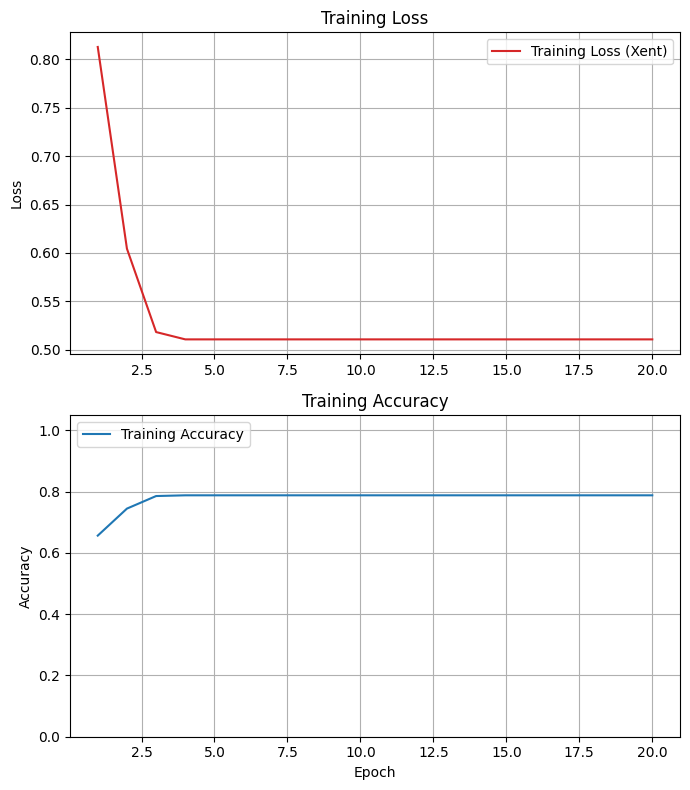

Final Training Loss:     0.5108
Final Training Accuracy: 0.7880


In [23]:
# Your code here -- add as many cells as you need

# Compute the number of steps (batches) per epoch

steps_per_epoch = int(np.ceil(len(X_train) / batch_size))

# Total number of training steps (needed for per-step schedulers like CosineDecay)

total_steps = epochs * steps_per_epoch

# CosineDecay schedule (per-step)
lr_schedule = CosineDecay(
    initial_learning_rate=best_ilr,
    decay_steps=total_steps,
    alpha=0.0  # Final LR = 0
)

model = Sequential([
Input(shape=(num_features,)),
Dense(64, activation='relu'),
Dense(32, activation='relu'),
Dense(num_classes, activation='softmax')])

# Compile the model
optimizer = Adam(learning_rate=best_ilr)
model.compile(optimizer=Adam(learning_rate=lr_schedule),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

# Train the model
epochs = 20
batch_size = best_batch_size

history = model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=1)

# Plot training history
plot_history(history)

best_model_train_accuracy = history.history['accuracy'][-1]
best_model_test_accuracy = model.evaluate(X_test, y_test, verbose=0)[1]



In [24]:
# Set a5a to the best training accuracy found by your best model

a5a = best_model_train_accuracy

In [25]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a5a = {a5a:.4f}') 

a5a = 0.7880


In [26]:
# Set a5b to the test accuracy found by your best model

a5b = best_model_test_accuracy

In [27]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a5b = {a5b:.4f}') 

a5b = 0.7824


## Reflection Questions (ungraded)

1. We trained on a perfectly balanced \~3.3% subset.
   If we *increase the subset size* (still balanced), how would you expect (a) training time, (b) the best **batch size**, and (c) the best **learning rate** to change? Why?

2. **Batch size trade-offs.**
   With epochs fixed, why do smaller batches often generalize better on tabular data than large batches? What would you change if you *must* use a large batch?

3. **More epochs, same LR.**
    If you doubled the number of epochs (no other changes), what do you think would happen to train loss/acc and test acc? 

4. **Epochs vs. LR.**
   It is natural to think that there is an inverse relationship between the number of epochs and learning rate: if you move more slowly, it will take you longer to reach your goal. Does this seem true given what we have seen in the experiments with learning rate?

# Appendix:  Forest Cover Type (Covertype) — Dataset Overview

This dataset pairs **cartographic features** of 30×30 m land plots with the **dominant tree cover type**. Your task is to predict the cover type from terrain and soil indicators—an archetypal **multi-class classification** problem on tabular data.

**At a glance**

* **Samples:** 581,012 original; we’ll use a **balanced subset** (e.g., 2747 per class) for faster, fairer training.
* **Features (54 total):**

  * **10 continuous:** elevation, aspect, slope, distances to hydrology/roads/fire points, and hillshade at 9 AM/noon/3 PM.
  * **44 binary:** **4 Wilderness\_Area** flags and **40 Soil\_Type** one-hot indicators.
* **Target (7 classes):** Spruce/Fir, Lodgepole Pine, Ponderosa Pine, Cottonwood/Willow, Aspen, Douglas-fir, Krummholz.

**Why it’s useful here**

* Realistic, **tabular** data with mixed feature types.
* Clear demonstration of **scaling** (continuous features) vs. **binary indicators**.
* Originally **imbalanced**, which motivates mindful evaluation (we avoid this by using a balanced subset).


Shape: (19229, 55)

Class distribution:
 Cover_Type
3    0.142857
2    0.142857
6    0.142857
5    0.142857
4    0.142857
1    0.142857
0    0.142857
Name: proportion, dtype: float64


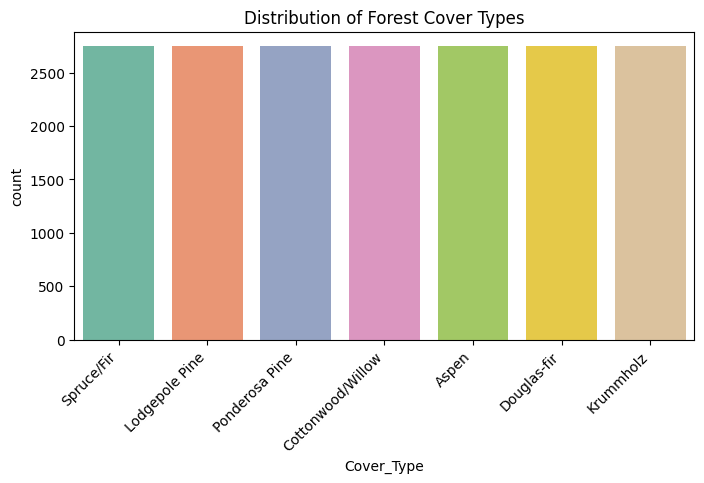

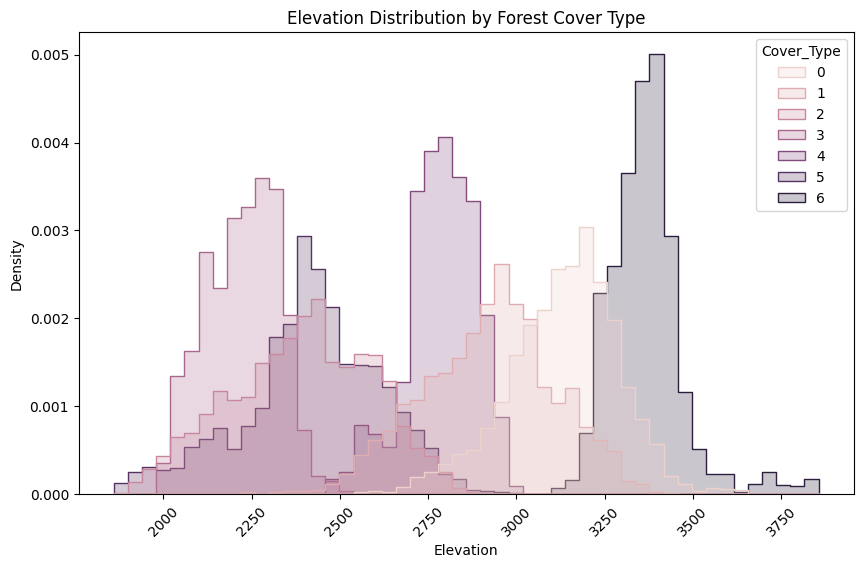

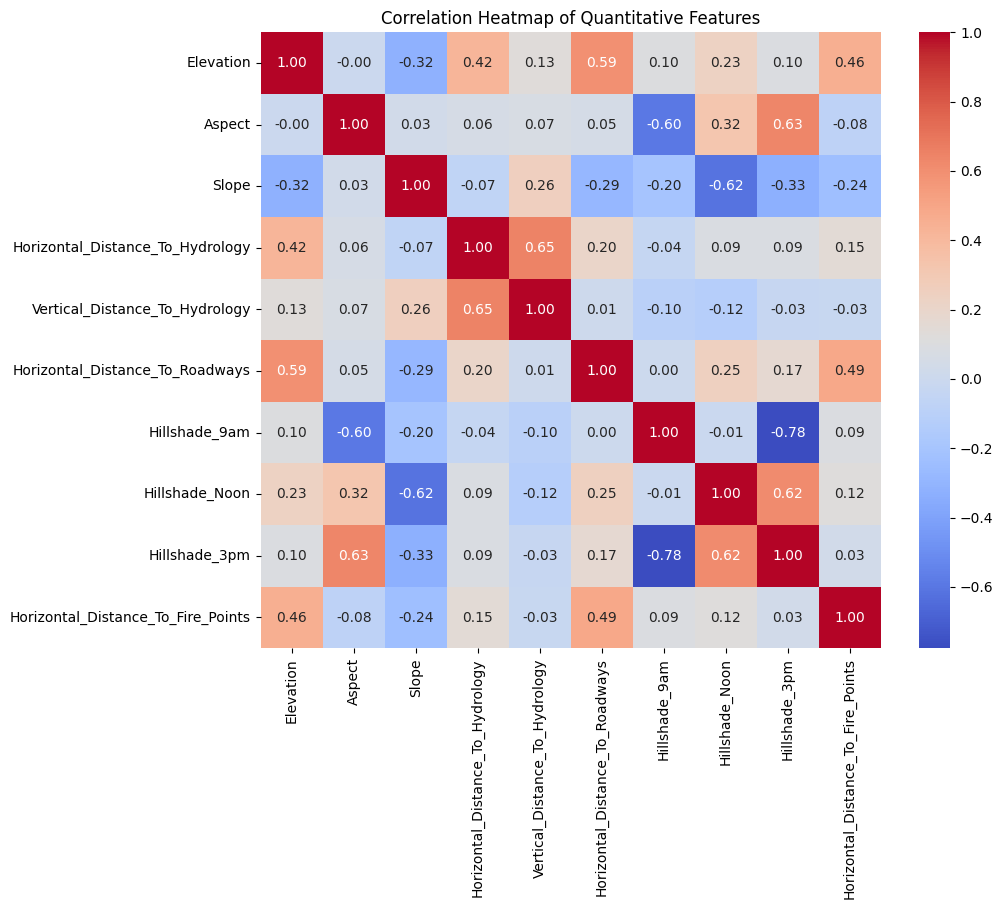

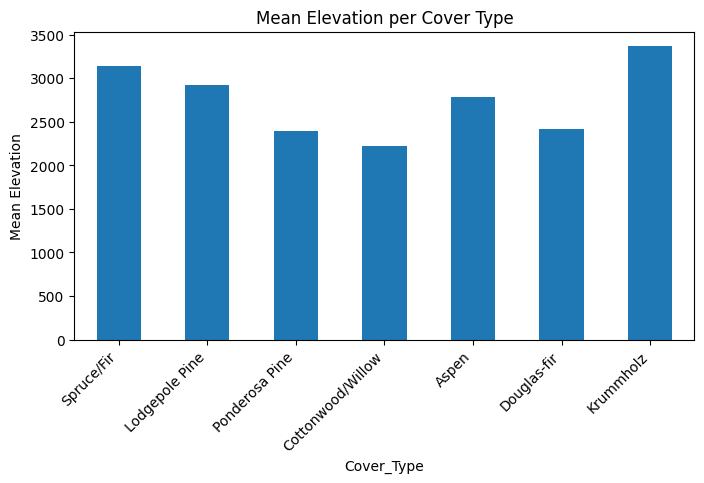

In [28]:
# Attach feature + class names
quant_features = [
    "Elevation", "Aspect", "Slope",
    "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways",
    "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points"
]
wilderness_features = [f"Wilderness_Area{i}" for i in range(1, 5)]
soil_features = [f"Soil_Type{i}" for i in range(1, 41)]

feature_names = quant_features + wilderness_features + soil_features
class_names = [
    "Spruce/Fir", "Lodgepole Pine", "Ponderosa Pine",
    "Cottonwood/Willow", "Aspen", "Douglas-fir", "Krummholz"
]

# Create dataframe from your subset
df = pd.DataFrame(X_sub, columns=feature_names)
df["Cover_Type"] = y_sub

# 1. Basic info
print("Shape:", df.shape)
print("\nClass distribution:\n", df["Cover_Type"].value_counts(normalize=True))

# 2. Class distribution plot
plt.figure(figsize=(8,4))
sns.countplot(x="Cover_Type", hue="Cover_Type", data=df, palette="Set2", legend=False)
plt.xticks(ticks=range(7), labels=class_names, rotation=45, ha="right")
plt.title("Distribution of Forest Cover Types")
plt.show()

# 3. Elevation distribution by class
plt.figure(figsize=(10,6))
sns.histplot(data=df, x="Elevation", hue="Cover_Type",
             bins=50, element="step", stat="density", common_norm=False)
plt.xticks(rotation=45)
plt.title("Elevation Distribution by Forest Cover Type")
plt.show()

# 4. Correlation heatmap (quantitative features only)
plt.figure(figsize=(10,8))
corr = df[quant_features].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of Quantitative Features")
plt.show()

# 5. Mean elevation per cover type
df.groupby("Cover_Type")["Elevation"].mean().plot(kind="bar", figsize=(8,4))
plt.xticks(ticks=range(7), labels=class_names, rotation=45, ha="right")
plt.ylabel("Mean Elevation")
plt.title("Mean Elevation per Cover Type")
plt.show()
